installing basic modules need in code but also more modules are installed in bellow code as experimenting

In [1]:
!pip install kagglehub numpy pandas scikit-learn matplotlib seaborn tldextract textblob whois swifter python-whois

downloading dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/malicious-urls-dataset")

print("Path to dataset files:", path)


c:\Users\rrpra\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\rrpra\.cache\kagglehub\datasets\sid321axn\malicious-urls-dataset\versions\1


verifying dataset 

In [3]:
import os
import numpy as np
import pandas as pd

df = pd.read_csv(os.path.join(path, "malicious_phish.csv"))
print(df.head())
print('=' * 150)
print(df.info())
print('=' * 150)
print(df['type'].value_counts())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


removing null and dublicate values

In [4]:
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())
df.drop_duplicates(inplace=True)
df.dropna()
print('=' * 150)
print("after deleting dublicates and nulls:-")
print('dublicates url = ',df.duplicated().sum())
print('null urls = ',df.isnull().sum())

dublicates url =  10066
null urls =  url     0
type    0
dtype: int64
after deleting dublicates and nulls:-
dublicates url =  0
null urls =  url     0
type    0
dtype: int64


this is the original functions (with little change to enable threading and pandas)  made by vivan to extract link attributes

In [5]:
#extract_features.py

import re
import socket
from urllib.parse import urlparse
import whois
import datetime
import ssl
import tldextract
try:
    with open("top-1m.csv", "r") as f:
        top_domains = {line.strip().split(',')[1] for line in f}
except:
    top_domains = None
#lexical
def extract_lexical_features(url):
    parsed = urlparse(url)
    hostname = parsed.hostname or ""
    ext = tldextract.extract(url)
    domain = f"{ext.domain}.{ext.suffix}"

    # suspicious tld - https://www.cybercrimeinfocenter.org/top-20-tlds-by-malicious-phishing-domains
    suspicious_tlds = {'zip', 'xyz', 'tk', 'top', 'gq', 'ga', 'ml', 'cyou', 'buzz', 'cf', 'icu', 'wang', 'live'}

    return {
        "domain": domain,
        #len>75 
        "url_length": len(url),
        #len>50 
        "hostname_length": len(hostname),
        #num>1 
        "num_dots": url.count('.'),
        #num>1 
        "num_hyphens": url.count('-'),
        #http 
        "has_https": int(url.startswith("https")),
        #num>4
        "num_subdirs": url.count('/'),
        #num>8
        "num_digits": sum(c.isdigit() for c in url),
        #num>4
        "num_params": url.count('='),
        #num>1
        "num_fragments": url.count('#'),
        #num>10
        "num_uppercase": sum(c.isupper() for c in url),
        #yes
        "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        #yes
        "has_port": int(':' in hostname),
        #yes
        "is_encoded": int('%' in url),
        #no
        "starts_with_www": int(hostname.startswith("www")),
        #yes
        "ends_with_suspicious_tld": int(ext.suffix in suspicious_tlds),

        #suspicious words - https://www.researchgate.net/figure/Suspicious-words-to-detect-phishing-URLs_fig6_364265241
        "suspicious_words": int(any(w in url.lower() for w in ['login', 'verify', 'account', 'update', 'secure', 'bank', 'lucky', 'bonus', 'gift', 'signin']))
    }
try:
    context = ssl.create_default_context()
except:
    context=None
#host based
def extract_host_features(domain):
    features = {
        "domain_age_days": -1,
        "dns_record_exists": 0,
        "has_ssl_certificate": 0,
        "is_alexa_top": 0
    }
    '''
    # dom age
    try:
        w = whois.whois(domain)
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        if creation_date:
            age = (datetime.datetime.now() - creation_date).days
            features["domain_age_days"] = age
    except:
        pass

    # DNS Check
    try:
        socket.gethostbyname(domain)
        features["dns_record_exists"] = 1
    except:
        pass
    '''
    # ssl check
    try:
        if context:
            with socket.create_connection((domain, 443), timeout=3) as sock:
                with context.wrap_socket(sock, server_hostname=domain) as ssock:
                    features["has_ssl_certificate"] = 1
    except:
        pass
    # alexa top 
    if top_domains:
        features["is_alexa_top"] = (domain in top_domains)

    return features

#main func
def extract_all_features(url):
    lexical_features = extract_lexical_features(url)
    host_features = extract_host_features(lexical_features["domain"])
    return {**lexical_features, **host_features}


bellow i and reducing the data set size so that i can check how much host attrubute affect link safety

In [6]:
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# Sample 10% from each class in the 'label' column
sample_df = df.groupby('type', group_keys=False).sample(n=20000, random_state=42)
tqdm.pandas()  # adds a progress bar to apply

# Apply feature extraction
lexical_features_df = sample_df['url'].progress_apply(lambda url: pd.Series(extract_lexical_features(url)))
lexical_features_df.head()
unique_domains = lexical_features_df["domain"].unique()
#extract_features_df = unique_domain['domain'].progress_apply(lambda domain: pd.Series(extract_host_features(domain)))
# Concatenate with original DataFrame (optional)
df_with_features = pd.concat([sample_df, lexical_features_df], axis=1)
df_with_features.head()

100%|██████████| 80000/80000 [00:15<00:00, 5298.28it/s]


,url,type,domain,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,num_fragments,num_uppercase,has_ip,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words
343443,cybermuse.gallery.ca/cybermuse/search/artist_e...,benign,gallery.ca,65,0,3,0,0,3,4,1,0,0,0,0,0,0,0,0
193033,fanpix.net/gallery/paul-gleason-pictures.htm,benign,fanpix.net,44,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0
376188,biogs.com/strictlycomedancing/bellingham.html,benign,biogs.com,45,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0
212737,mylife.com/c-1090135275,benign,mylife.com,23,0,1,1,0,1,10,0,0,0,0,0,0,0,0,0
246981,mcshane-construction.com/leadership.aspx,benign,mcshane-construction.com,40,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0


bellow function is taking too much time to calcualte host attributes like domain age etc so i am just experimenting with threading to reduce the time


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

results = {}
with ThreadPoolExecutor(max_workers=1000) as executor:
    futures = {executor.submit(extract_host_features, d): d for d in unique_domains}

    for future in tqdm(as_completed(futures), total=len(futures)):
        domain = futures[future]
        try :
            results[domain] = future.result()
        except Exception as e:
            results[domain] = None

# To convert to DataFrame:
host_features_df = pd.DataFrame.from_dict(results, orient='index').reset_index().rename(columns={"index": "domain"})
host_features_df.head()






 18%|█▊        | 5319/29276 [00:52<03:56, 101.18it/s] 


In [ ]:
for column in host_features_df.columns:
    if column != "domain":
        print(column, host_features_df[column].value_counts())

domain_age_days domain_age_days
-1    29276
Name: count, dtype: int64
dns_record_exists dns_record_exists
0    29276
Name: count, dtype: int64
has_ssl_certificate has_ssl_certificate
0    22497
1     6779
Name: count, dtype: int64
is_alexa_top is_alexa_top
False    26086
True      3190
Name: count, dtype: int64


In [ ]:

df_with_features = pd.merge(df_with_features, host_features_df, on='domain')
df_with_features["label"] = df_with_features["type"].apply(lambda t:1 if t == 'benign' else 0)

df_with_features.head()



KeyError: 'domain'

In [ ]:
df_with_features.drop(["url", "domain","type"],axis=1,inplace=True)
df_with_features.head()

,url_length,hostname_length,num_dots,num_hyphens,has_https,num_subdirs,num_digits,num_params,num_fragments,num_uppercase,...,has_port,is_encoded,starts_with_www,ends_with_suspicious_tld,suspicious_words,domain_age_days,dns_record_exists,has_ssl_certificate,is_alexa_top,label
0,65,0,3,0,0,3,4,1,0,0,...,0,0,0,0,0,-1,0,1,False,1
1,44,0,2,2,0,2,0,0,0,0,...,0,0,0,0,0,-1,0,1,False,1
2,45,0,2,0,0,2,0,0,0,0,...,0,0,0,0,0,-1,0,1,False,1
3,23,0,1,1,0,1,10,0,0,0,...,0,0,0,0,0,-1,0,1,True,1
4,40,0,2,1,0,1,0,0,0,0,...,0,0,0,0,0,-1,0,1,False,1


In [ ]:
for column in df_with_features.columns:
    if column != "domain":
        print(column, df_with_features[column].value_counts()[:10])

url_length url_length
33    3395
34    2589
32    2038
35    1916
31    1762
27    1718
41    1533
40    1441
38    1343
36    1338
Name: count, dtype: int64
hostname_length hostname_length
0     34119
13     5475
14     5373
12     4937
20     4070
15     3740
17     2223
16     2179
19     1907
18     1821
Name: count, dtype: int64
num_dots num_dots
2     24950
3     23853
1     15767
4     12249
5      1565
6       639
7       315
8       131
10      126
9       113
Name: count, dtype: int64
num_hyphens num_hyphens
0    50768
1    13944
2     4871
3     2698
4     1889
5     1358
6     1038
7      694
8      657
9      527
Name: count, dtype: int64
has_https has_https
0    72763
1     7237
Name: count, dtype: int64
num_subdirs num_subdirs
3    26189
4    17785
2     9938
1     7723
5     6050
0     5276
6     3087
7     2006
8      931
9      470
Name: count, dtype: int64
num_digits num_digits
0     28537
4      5544
2      4853
3      4646
1      4355
5      3900
6      2940
10    

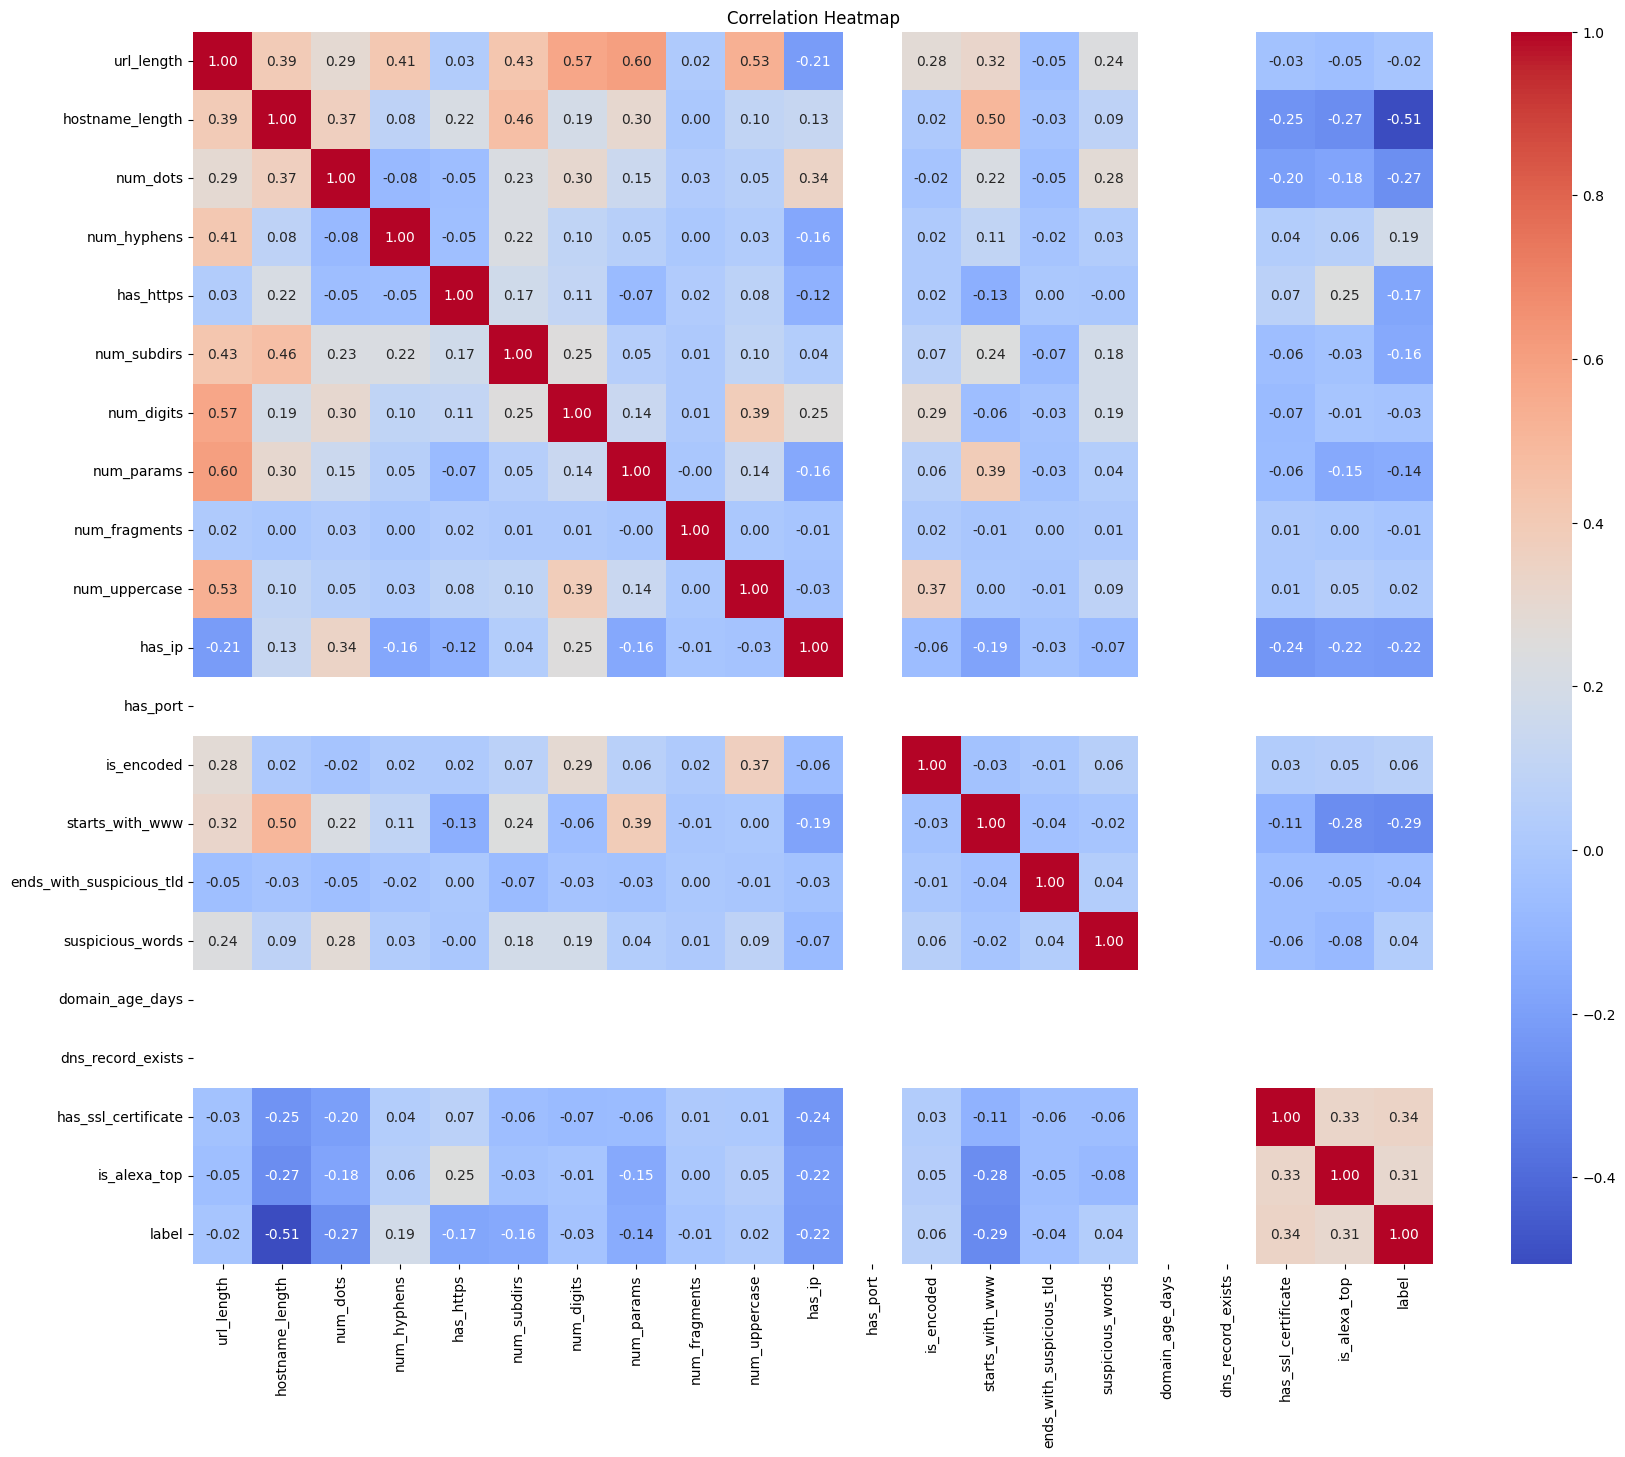

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = df_with_features.corr()
f=open("corr.csv",'w')
f.write(correlation.to_csv())
f.close()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


i have worked till here from next part i have just exprementing it is not working and currently not part of our main code



In [ ]:
import pandas as pd
import re
import tldextract
from urllib.parse import urlparse
from collections import Counter
import math
import string
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# List of suspicious keywords often found in phishing URLs


# Function to calculate Shannon entropy of a string
def shannon_entropy(s):
    if not s:
        return 0
    probs = [freq / len(s) for freq in Counter(s).values()]
    return -sum(p * math.log2(p) for p in probs)

# Function to check if URL uses an IP address instead of a domain
def has_ip_address(url):
    ip_pattern = r'(\d{1,3}\.){3}\d{1,3}'
    return 1 if re.search(ip_pattern, url) else 0

# Main vectorizing function
def extract_url_features(df):
    # Basic features
    df['url_lower'] = df['url'].str.lower()
    df['url_length'] = df['url'].str.len()
    df['num_dots'] = df['url'].str.count(r'\.')
    df['num_digits'] = df['url'].str.count(r'\d')
    df['num_special_chars'] = df['url'].apply(lambda x: sum(c in string.punctuation for c in x))
    df['has_at'] = df['url'].str.contains('@').astype(int)
    df['has_https'] = df['url'].str.startswith('https').astype(int)
    df['num_subdirs'] = df['url'].apply(lambda x: urlparse(x).path.count('/'))
    df['ip_present'] = df['url'].apply(has_ip_address)

    # Extract tld using tldextract
    df['tld'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)

    # Shannon entropy
    df['entropy'] = df['url_lower'].apply(shannon_entropy)

    

    # Drop helper columns
    df.drop(columns=['url_lower'], inplace=True)
    df['tld'] = le.fit_transform(df['tld'])
    return df



df_features = extract_url_features(df.copy())
df_features.head()

KeyboardInterrupt: 

In [ ]:
features = ['url_length',	'num_dots',	'num_digits',	'num_special_chars',	'has_at',	'has_https',	'num_subdirs',	'ip_present',	'entropy', 'tld']
small_df = df_features[features+['type']]

In [ ]:
#avg_featues = small_df.groupby('type')[features].mean()
#avg_featues

In [ ]:
small_df['label'] = small_df['type'].apply(lambda x: 1 if x == 'benign' else 0)
y = small_df['label']
small_df.head()

,url_length,num_dots,num_digits,num_special_chars,has_at,has_https,num_subdirs,ip_present,entropy,tld,type,label
0,16,2,0,3,0,0,0,0,3.375000,164,phishing,0
1,35,2,1,5,0,0,2,0,4.079143,157,benign,1
2,31,2,1,5,0,0,3,0,3.708093,660,benign,1
3,88,3,7,18,0,0,1,0,4.660343,67,defacement,0
4,235,2,22,14,0,0,1,0,4.980518,583,defacement,0


In [ ]:

from sklearn.model_selection import train_test_split

X = small_df[features]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
def create_models(model_name):
    model = model_name()  # Instantiate the model based on the provided name
    model.fit(X_train, y_train)  # Fit the
    f= open(fr"models/{model_name.__name__}_model_link_safety_checker.pkl", "wb")
    pickle.dump(model, f)  # Save the model for later use
    f.close()
    return model




In [ ]:
XGBmodel = create_models(XGBClassifier)
NBmodel = create_models(MultinomialNB)
Rfmodel = create_models(RandomForestClassifier)

KeyboardInterrupt: 

In [ ]:
def evaluate(model,name): 
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:",accuracy)
    report = classification_report(y_test, y_pred)
    print(report)
    tp,tn,fp,fn = 0,0,0,0
    ly=np.array(y_test)
    print('total test case:-',len(ly),'total dataset size:-',len(X))
    match = y_pred == ly
    mismatch = ~match

    # Vectorized counts
    tp = np.sum((match) & (y_pred == 1))
    tn = np.sum((match) & (y_pred == 0))
    fp = np.sum((mismatch) & (y_pred == 1))
    fn = np.sum((mismatch) & (y_pred == 0))
    print(f'tp={tp},tn={tn},fp={fp},fn={fn}')
    f=open(fr"models/{name}_model_link_safety_check_score.txt", "w")
    f.write(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
    f.write((classification_report(y_test, y_pred))+'\n')
    f.write(f'tp={tp},tn={tn},fp={fp},fn={fn}\n')
    f.close()

In [ ]:
print(('XGB').center(100,'='))
evaluate(XGBmodel,'XGBClassifier')
print(('Random Forest Model').center(100,'='))
evaluate(Rfmodel,'RandomForestClassifier')
print(('multinomial navibase').center(100,'='))
evaluate(NBmodel,'multinomialNBClassifier')

================================================XGB=================================================
Accuracy: 0.9069916162994736
              precision    recall  f1-score   support

           0       0.89      0.82      0.85     42721
           1       0.91      0.95      0.93     85504

    accuracy                           0.91    128225
   macro avg       0.90      0.89      0.89    128225
weighted avg       0.91      0.91      0.91    128225

total test case:- 128225 total dataset size:- 641125
tp=81269,tn=35030,fp=7691,fn=4235
========================================Random Forest Model=========================================
Accuracy: 0.9199064145057516
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     42721
           1       0.93      0.95      0.94     85504

    accuracy                           0.92    128225
   macro avg       0.91      0.90      0.91    128225
weighted avg       0.92      0.92      0.92    128225


In [ ]:
def predict_url(model, url):
    extracted_url = extract_url_features(pd.DataFrame({'url': [url]}))
    prediction = model.predict(extracted_url[features])
    return 'benign' if prediction[0] == 1 else 'malicious'
urls = ['oceansofgamess.com/','oceanofgames.com/','oceanofgamesu.com/','oceantogames.com/','colab.research.google.com/','myaccount.google.com/?utm_source=sign_in_no_continue&pli=1','example.com/','mp3raid.com/music/krizz_kaliko.html']

for url in urls:
    print(f"Prediction for '{url}': {predict_url(XGBmodel, url)}")
    print(f"Prediction for '{url}': {predict_url(Rfmodel, url)}")
    print(f"Prediction for '{url}': {predict_url(NBmodel, url)}")


Prediction for 'oceansofgamess.com/': benign
Prediction for 'oceansofgamess.com/': benign
Prediction for 'oceansofgamess.com/': benign
Prediction for 'oceanofgames.com/': benign
Prediction for 'oceanofgames.com/': benign
Prediction for 'oceanofgames.com/': benign
Prediction for 'oceanofgamesu.com/': benign
Prediction for 'oceanofgamesu.com/': benign
Prediction for 'oceanofgamesu.com/': benign
Prediction for 'oceantogames.com/': benign
Prediction for 'oceantogames.com/': benign
Prediction for 'oceantogames.com/': benign
Prediction for 'colab.research.google.com/': benign
Prediction for 'colab.research.google.com/': benign
Prediction for 'colab.research.google.com/': benign
Prediction for 'myaccount.google.com/?utm_source=sign_in_no_continue&pli=1': malicious
Prediction for 'myaccount.google.com/?utm_source=sign_in_no_continue&pli=1': malicious
Prediction for 'myaccount.google.com/?utm_source=sign_in_no_continue&pli=1': benign
Prediction for 'example.com/': benign
Prediction for 'example